In [1]:
#importing the required stuff

from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [2]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [3]:
# set number of assets (= number of qubits)
num_assets = 10
seed = 1234
#### Using data from yahoo finance
data = YahooDataProvider(
        tickers= ["JPM", "GS", "MSFT", "AAPL", "CO", "WMT", "DIS", "BA", "MCD", "NKE"],
        start=datetime.datetime(2016, 1, 1),
        end=datetime.datetime(2020, 12, 31),
    )
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


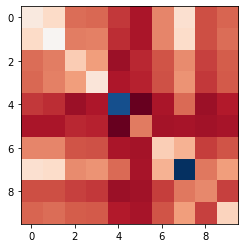

In [4]:
# plot sigma
plt.imshow(sigma, interpolation="nearest", cmap = "RdBu")
plt.show()


In [5]:
print(mu)
print('\n')
print(sigma)

[ 8.06257959e-04  5.58697674e-04  1.32746809e-03  1.53461923e-03
 -6.77636492e-05  8.68184590e-04  6.31931930e-04  8.20496704e-04
  6.71548443e-04  8.52882584e-04]


[[ 3.70631985e-04  3.30215743e-04  1.78037568e-04  1.72406606e-04
   1.19586545e-04  7.18588722e-05  2.08314517e-04  3.43870669e-04
   1.42599680e-04  1.71443002e-04]
 [ 3.30215743e-04  4.01907535e-04  1.97599279e-04  2.01773341e-04
   1.06832191e-04  7.42431062e-05  2.07606519e-04  3.34142122e-04
   1.43508594e-04  1.77971922e-04]
 [ 1.78037568e-04  1.97599279e-04  3.05731010e-04  2.37242851e-04
   5.64186543e-05  9.86290555e-05  1.49939630e-04  2.14636433e-04
   1.28565058e-04  1.61289392e-04]
 [ 1.72406606e-04  2.01773341e-04  2.37242851e-04  3.61291516e-04
   7.73419709e-05  9.18270746e-05  1.48075046e-04  2.24812404e-04
   1.18013876e-04  1.56006023e-04]
 [ 1.19586545e-04  1.06832191e-04  5.64186543e-05  7.73419709e-05
   7.74103544e-04 -2.76926064e-06  7.19008382e-05  1.76627824e-04
   5.80970488e-05  8.14988173e-05]

In [6]:
q = 0.5  # set risk factor
budget = num_assets // 10  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


<QuadraticProgram: minimize 0.00018531599232289966*x_0^2 + 0.00033021574311030..., 10 variables, 1 constraints, 'Portfolio optimization'>

In [7]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [8]:
#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], value -0.0014

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 0 0 0 0 0]	-0.0014		1.0000
[1 1 1 1 1 1 1 1 1 1]	82.3762		0.0000
[0 0 0 0 1 0 1 0 1 0]	4.0676		0.0000
[1 0 1 1 1 0 1 0 1 0]	25.4227		0.0000
[0 0 1 1 1 0 1 0 1 0]	16.2697		0.0000
[1 1 0 1 1 0 1 0 1 0]	25.4238		0.0000
[0 1 0 1 1 0 1 0 1 0]	16.2706		0.0000
[1 0 0 1 1 0 1 0 1 0]	16.2703		0.0000
[0 0 0 1 1 0 1 0 1 0]	9.1515		0.0000
[1 1 1 0 1 0 1 0 1 0]	25.4240		0.0000
[0 1 1 0 1 0 1 0 1 0]	16.2708		0.0000
[1 0 1 0 1 0 1 0 1 0]	16.2705		0.0000
[0 0 1 0 1 0 1 0 1 0]	9.1516		0.0000
[1 1 0 0 1 0 1 0 1 0]	16.2716		0.0000
[0 1 0 0 1 0 1 0 1 0]	9.1526		0.0000
[1 0 0 0 1 0 1 0 1 0]	9.1523		0.0000
[1 1 1 1 0 0 1 0 1 0]	25.4226		0.0000
[1 1 1 1 1 0 1 0 1 0]	36.6103		0.0000
[0 1 1 1 0 0 1 0 1 0]	16.2694		0.0000
[1 0 1 1 0 0 1 0 1 0]	16.2691		0.0000
[0 0 1 1 0 0 1 0 1 0]	9.1501		0.0000
[1 1 0 1

In [9]:
#### VQE solution
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit_optimization\algorithms\optimization_algorithm.py:138: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


Optimal: selection [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], value -0.0014

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 0 0 0 0 0]	-0.0004		0.5237
[0 0 0 0 0 0 1 0 0 0]	-0.0005		0.4728
[0 1 0 0 0 0 0 0 1 0]	1.0162		0.0008
[1 0 0 0 0 0 1 0 0 0]	1.0161		0.0003
[1 0 0 0 0 0 0 0 0 0]	-0.0006		0.0002
[0 1 0 0 0 1 0 0 0 0]	1.0159		0.0002
[0 1 0 0 0 0 0 1 0 0]	1.0165		0.0001
[1 1 0 0 0 0 0 0 1 0]	4.0670		0.0001
[0 1 0 0 0 0 0 0 0 1]	1.0161		0.0001
[0 1 0 0 0 0 1 0 0 1]	4.0669		0.0001
[0 1 0 0 1 0 1 0 0 0]	4.0679		0.0001
[0 0 1 0 0 0 0 0 0 0]	-0.0012		0.0001
[0 0 0 0 0 1 0 0 1 0]	1.0157		0.0001
[0 0 0 0 0 0 0 0 0 1]	-0.0007		0.0001
[0 0 0 1 0 0 0 0 1 0]	1.0152		0.0001
[0 0 0 0 1 0 0 0 0 0]	0.0005		0.0001
[0 0 0 0 0 0 0 0 1 1]	1.0158		0.0001
[0 1 0 1 0 0 0 0 0 0]	1.0155		0.0000
[0 1 1 0 0 0 1 0 0 0]	4.0665		0.0000
[0 0 0 0 0 0 1 0 1 0]	1.0161		0.0000
[0 0 0 0 0 0 0 0 1 0]	-0.0006		0.0000
[0 0 0 0 1 0 0 0 

In [10]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)



Optimal: selection [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], value -0.0014

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 0 0 0]	1.0170		0.2023
[0 0 0 0 0 0 0 1 0 0]	-0.0004		0.0554
[0 1 0 0 0 0 0 0 0 0]	-0.0004		0.0554
[0 0 0 0 1 0 0 0 0 0]	0.0005		0.0553
[1 0 0 0 0 0 0 0 0 0]	-0.0006		0.0553
[0 0 0 0 0 0 1 0 0 0]	-0.0005		0.0552
[0 0 0 0 0 0 0 0 0 1]	-0.0007		0.0551
[0 0 0 0 0 0 0 0 1 0]	-0.0006		0.0551
[0 0 1 0 0 0 0 0 0 0]	-0.0012		0.0550
[0 0 0 1 0 0 0 0 0 0]	-0.0014		0.0549
[0 0 0 0 0 1 0 0 0 0]	-0.0008		0.0549
[0 1 0 0 0 0 0 1 0 0]	1.0165		0.0053
[0 0 0 0 1 0 0 1 0 0]	1.0172		0.0052
[1 0 0 0 0 0 0 1 0 0]	1.0163		0.0052
[1 1 0 0 0 0 0 0 0 0]	1.0163		0.0052
[0 0 0 0 0 0 1 1 0 0]	1.0164		0.0052
[0 1 0 0 1 0 0 0 0 0]	1.0172		0.0052
[0 1 0 0 0 0 1 0 0 0]	1.0164		0.0052
[0 0 0 0 0 0 0 1 0 1]	1.0161		0.0052
[1 0 0 0 1 0 0 0 0 0]	1.0169		0.0052
[0 0 0 0 0 0 0 1 1 0]	1.0162		0.0052
[0 0 0 0 1 0 1

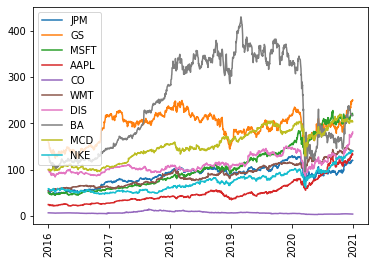

In [11]:
stocks = ["JPM", "GS", "MSFT", "AAPL", "CO", "WMT", "DIS", "BA", "MCD", "NKE"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2016, 1, 1),
            end=datetime.datetime(2020, 12, 31),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()